# Flaredown user similarity by condition

## Configuration

In [1]:
# Production DB credentials
MONGO_HOST = "candidate.53.mongolayer.com"
MONGO_PORT = 10549
MONGO_DBNAME = "production"
MONGO_USERNAME = "production"
MONGO_PASSWORD = "8WfakpFkMtFkxP7n"

## Extract data

In [2]:
import pymongo

In [3]:
client = pymongo.MongoClient(MONGO_HOST, MONGO_PORT)
db = client[MONGO_DBNAME]
db.authenticate(MONGO_USERNAME, MONGO_PASSWORD)

True

In [4]:
def users_conditions():
    # grab every condition each user has ever tracked
    results = list(db.entries.aggregate(
        [
            {"$group": {"_id": "$user_id", "conditions": {"$addToSet": "$conditions"}}}
        ]
    ))
    users = [result["_id"] for result in results]
    conditions = [[condition.lower() for condition in result["conditions"][0]] for result in results]
    return users, conditions

users, texts = users_conditions()  # in topic modelling terms, user = text, condition = vocab_item

## Build model

In [5]:
from gensim import corpora, models

dictionary = corpora.Dictionary(texts)  # build dictionary, which maps condition to id
dictionary.save("/tmp/conditions.dict")

corpus = [dictionary.doc2bow(text) for text in texts]  # transform the texts into a vector stream corpus
corpora.MmCorpus.serialize("/tmp/corpus.mm", corpus)

In [6]:
TF_IDF = False

tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

if TF_IDF:
    corpus = corpus_tfidf

In [7]:
# initialize model with high number of topics to apply 'elbow rule' below
lsi_full = models.LsiModel(corpus, id2word=dictionary, num_topics=20)
corpus_lsi_full = lsi_full[corpus]  # apply model to corpus

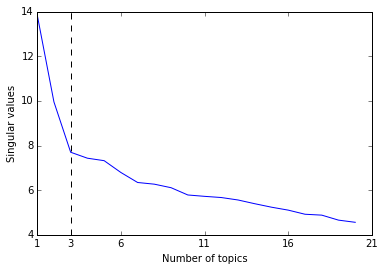

In [8]:
%matplotlib inline
from matplotlib import pyplot as plt

MAGIC_NUMBER = 3  # find where the plotted line becomes much less steep
                  # this is the optimal number of topics in the corpus

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.plot(lsi_full.projection.s)
ax.axvline(MAGIC_NUMBER - 1, color='k', linestyle='--')
ax.set_xticks(list(ax.get_xticks()) + [MAGIC_NUMBER - 1])
ax.set_xticklabels([int(x + 1) for x in ax.get_xticks()])
ax.set_xlabel("Number of topics")
ax.set_ylabel("Singular values")

plt.show()

In [9]:
# initialize model with high number of topics to apply 'elbow rule' below
lsi_optimal = models.LsiModel(corpus, id2word=dictionary, num_topics=MAGIC_NUMBER)
corpus_lsi_optimal = lsi_optimal[corpus]  # apply model to corpus

## Construct pairwise similarity metric

In [10]:
from scipy import spatial

In [11]:
def similar(a, b):
    if a not in users:
        return "User {} does not exist.".format(a)
    if b not in users:
        return "User {} does not exist.".format(b)

    a_i = users.index(a)
    b_i = users.index(b)

    a_coords = [tup[1] for tup in corpus_lsi_optimal[a_i]]
    b_coords = [tup[1] for tup in corpus_lsi_optimal[b_i]]
    
    if len(a_coords) == 0:
        return "User {} has not tracked any conditions.".format(a)
    if len(b_coords) == 0:
        return "User {} has not tracked any conditions.".format(b)
    
    return 1 - spatial.distance.cosine(a_coords, b_coords)

## Demonstration of similarity

In [12]:
def conditions_for_user(user_id):
    if user_id not in users:
        return "User {} does not exist.".format(user_id)
    return texts[users.index(user_id)]

In [13]:
def pretty_similarity(a, b):
    print("{}: ".format(a), conditions_for_user(a))
    print("{}: ".format(b), conditions_for_user(b))
    try:
        print("Similarity: ", "{:.2f}".format(similar(a, b)))
    except ValueError:
        print("Cannot compute similarity.")


In [14]:
print(pretty_similarity(200, 479))

200:  ['lupus', 'migraine']
479:  ['fibromyalgia', 'polycystic ovary syndrome', 'tmj disorders', 'trigeminal neuralgia', 'persistent genital arousal disorder', 'migraine', 'hypothyroidism']
Similarity:  0.74
None


## Global similarity

In [15]:
from gensim import similarities

index = similarities.MatrixSimilarity(lsi_optimal[corpus])
index.save("/tmp/conditions.index")

In [16]:
def global_similarity(user_id):
    if user_id not in users:
        return "User {} does not exist.".format(user_id)
    user_similarities = [(users[i], score) for i, score in enumerate(index[corpus_lsi_optimal[users.index(user_id)]])]
    return sorted(user_similarities, key=lambda x: x[1], reverse=True)

In [17]:
def pretty_neighbours(user_id):
    if user_id not in users:
        print("User {} does not exist.".format(user_id))
    print("{0}         {1}".format(user_id, conditions_for_user(user_id)))
    print("----------------------")
    for user in global_similarity(user_id)[1:20]:
        print("{0[0]}: {0[1]:.2f}   {1}".format(user, conditions_for_user(user[0])))

In [18]:
print(pretty_neighbours(975))

975         ['arthritis', 'fibromyalgia', 'gerd', 'insomnia', 'migraine', 'herniated disks', 'spondylitis', 'post concussive syndrome', 'ibd']
----------------------
479: 1.00   ['fibromyalgia', 'polycystic ovary syndrome', 'tmj disorders', 'trigeminal neuralgia', 'persistent genital arousal disorder', 'migraine', 'hypothyroidism']
147: 1.00   ['bipolar disorder', 'fibromyalgia', 'migraine']
649: 1.00   ['asthma', 'chronic fatigue syndrome', 'diabetes', 'fibromyalgia', 'migraine', 'pots']
631: 1.00   ['arthritis', 'fibromyalgia', 'migraine', 'plantar fasciitis', 'ibs']
291: 1.00   ['fibromyalgia', 'migraine', 'myalgic encephalomyelitis', 'generalized anxiety disorder']
961: 1.00   ['fibromyalgia', 'migraine', 'occipital neuralgia']
574: 1.00   ['fibromyalgia', 'migraine']
240: 1.00   ['fibromyalgia', 'migraine']
444: 1.00   ['fibromyalgia', 'migraine']
65: 1.00   ['fibromyalgia', 'irritable bowel syndrome', 'migraine', 'osteoarthritis']
735: 1.00   ['fibromyalgia', 'migraine', 'polycys